# 1. Introduction

In the competitive landscape of e-commerce logistics, timely delivery is a key factor for customer satisfaction and operational efficiency. This project explores historical delivery data from the Olist marketplace, a large Brazilian e-commerce platform, to predict whether an order will be delivered late.

Predicting delivery delays enables proactive actions such as customer communication, internal process optimization, and carrier prioritization. It also supports strategic decisions regarding logistics partnerships and resource allocation.

This notebook documents the entire end-to-end process, from data cleaning and exploratory analysis to feature engineering and machine learning modeling, aiming to build a robust predictive system for delivery delays.


# 2. Project Objectives

This project aims to:

- Consolidate and preprocess data from multiple sources (orders, items, customers, sellers, products, geolocation, payments).
- Perform a thorough exploratory data analysis (EDA) to understand delivery patterns.
- Engineer new features relevant to logistics and geography.
- Build and evaluate machine learning models to predict whether an order will be delivered later than the estimated date.
- Interpret the model's behavior using explainable AI tools to derive actionable insights.


# 3. Data treatment

## Data Loading

In [66]:
# import libraries
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pandas.io.parquet import to_parquet

In [67]:
# Define path to src folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

In [68]:
# Import data_loader 
from data_loader import load_olist_datasets

In [69]:
# Data loading
dfs = load_olist_datasets(data_folder="data/raw")

## Data Cleaning

### Missing Values and Duplicates

Before any modeling, it's essential to ensure data consistency and completeness. The following scan checks for duplicated rows and missing values in each table of the Olist dataset.


In [70]:
# import data cleaning
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_cleaning import check_missing_and_duplicates

In [71]:
# Checking shape, duplicated rows and missing values.
check_missing_and_duplicates(dfs)

--- customer ---
Shape: (99441, 5)
Duplicated rows: 0
Missing values:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

--- geolocation ---
Shape: (1000163, 5)
Duplicated rows: 261831
Missing values:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

--- orders ---
Shape: (99441, 8)
Duplicated rows: 0
Missing values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

--- order_items ---
Shape: (112650, 7)
Duplicated rows: 0
Missing values:
order_id               0
order_item_id         

### Orders Dataframe: treatment and Type Conversion

In [72]:
orders = dfs["orders"]  # Extract the 'orders' DataFrame

#### Null and Missing values treatment

In [73]:
# Identifying null or missing values.
print(orders.isnull().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


There are null numerical values in the order approval date column, indicating that the orders were not approved. The shipping date column also contains null values, indicating that the order was not shipped. Lastly, the delivery date column also contains null values, indicating that the order was not delivered. The first step will be check the order status, because it's just possible to verify if the order will be late, when the order status is delivered ou shipped.

In [74]:
# checking the proportiond by order status
status_count = orders['order_status'].value_counts(normalize=True).reset_index()
status_count.columns = ['order_status', 'proportion']
print(status_count)

  order_status  proportion
0    delivered    0.970203
1      shipped    0.011132
2     canceled    0.006285
3  unavailable    0.006124
4     invoiced    0.003158
5   processing    0.003027
6      created    0.000050
7     approved    0.000020


Filtering Orders by Status

In the Olist dataset, the `order_status` column represents the current state of each order. However, not all status are relevant for delivery performance analysis.

Below is the distribution of `order_status` in the dataset:

- **delivered**: 97.0%
- **shipped**: 1.1%
- **canceled**, **unavailable**, **invoiced**, **processing**, **created**, and **approved**: together less than 2%

For this project, we are focusing on evaluating delivery performance and understanding delays. Therefore, we filtered the dataset to include only:

- `delivered`: orders that were completed and successfully delivered to the customer.
- `shipped`: orders that were dispatched but not yet confirmed as delivered (can be useful for future delivery predictions).

All other statuses were excluded because they:
- Do not reach the delivery phase.
- Would introduce noise into delivery time calculations.
- Do not contain a valid delivery timestamp.

This filtering step ensures that we focus only on relevant records for our objective of analyzing or modeling delivery behavior.


In [75]:
# Keep only orders that were delivered or shipped
orders = orders[orders['order_status'].isin(['delivered', 'shipped'])].copy()

In [76]:
# Identifying null or missing values.
print(orders.isnull().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date        2
order_delivered_customer_date    1115
order_estimated_delivery_date       0
dtype: int64


Some orders have missing values in `order_delivered_customer_date`. This is expected for `shipped` orders that have not yet been delivered.

We chose **not to drop** or impute these values at this stage, because:

- They represent valuable information about current logistics status.
- They can help identify potentially late orders in later steps.
- This decision aligns with a careful, iterative data science workflow.


In [77]:
# Checking column data types
print(orders.dtypes)

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


#### Columns type conversion


Converting date columns from object to datetime and "order status" column from object to category

In [78]:
# import data cleaning
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_cleaning import order_type_conversion

orders = order_type_conversion(orders)
print(orders.dtypes)


order_id                                 object
customer_id                              object
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


### Orders Items Dataframe: treatment and Type Conversion

In [79]:
order_items = dfs["order_items"]  # Extract the 'order_items' DataFrame

There are no null or missing values in the dataframe.

#### Columns type conversion

In [80]:
# Checking column data types
print(order_items.dtypes)

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


Converting date columns from object to datetime

In [81]:
order_items["shipping_limit_date"] = pd.to_datetime(
    order_items["shipping_limit_date"], errors="coerce")

### Customers Dataframe: treatment and Type Conversion

In [82]:
customer = dfs["customer"]  # Extract the 'customers' DataFrame

There are no null or missing values in the dataframe.

#### Columns type conversion

In [83]:
# Checking column data types
print(customer.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


The column data types are correct.

### Products Dataframe: treatment and Type Conversion

In [84]:
products = dfs["products"]  # Extract the 'products' DataFrame

#### Null and Missing values treatment

In [85]:
# Identifying null or missing values.
print(products.isnull().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [86]:
# Checking null values proportion
missing_info = products.isna().mean().round(4) * 100

print(missing_info)

product_id                    0.00
product_category_name         1.85
product_name_lenght           1.85
product_description_lenght    1.85
product_photos_qty            1.85
product_weight_g              0.01
product_length_cm             0.01
product_height_cm             0.01
product_width_cm              0.01
dtype: float64


Feature Selection – Dropping Non-Essential Columns

We decided to drop the following columns from the `products` dataset:

- `product_name_lenght`
- `product_description_lenght`
- `product_photos_qty`

### Why?
These features provide only metadata (e.g., character counts or image counts) rather than meaningful product characteristics. They are also highly correlated with missing or inconsistent data (610 missing values). 

Additionally, they are unlikely to contribute to our predictive model or analysis of delivery delays, which focus more on physical and logistical attributes such as product weight and dimensions.


In [87]:
# Dropping columns not relevant for delivery analysis
products.drop(columns=[
    'product_name_lenght', 
    'product_description_lenght', 
    'product_photos_qty'
], inplace=True)


Null values were found in the product category name, which will be filled with "Unknown". Finally, two null values were found in the columns: weight, length, height, and width, these will be filled with the median.

In [88]:
# Null and missing values treatment.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_cleaning import products_treatment
products_treatment(products)

print(products.isnull().sum())

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64


### Customers Dataframe: treatment and Type Conversion

In [89]:
# Checking column data types
print(customer.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


The column data types are correct.

### Sellers Dataframe: treatment and Type Conversion

In [90]:
sellers = dfs["sellers"]  # Extract the 'sellers' DataFrame

There are no null or missing values in the dataframe.

#### Columns type conversion

In [91]:
# Checking column data types
print(sellers.dtypes)

seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object


The column data types are correct.

### Payments Dataframe: treatment and Type Conversion

In [92]:
payments = dfs["payments"]  # Extract the 'payments' DataFrame

There are no null or missing values in the dataframe.

#### Columns type conversion

In [93]:
# Checking column data types
print(payments.dtypes)

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


Converting 'payment_type' column from object to category.

In [94]:
payments["payment_type"] = payments["payment_type"].astype("category")

### Geolocation: treatment and Type Conversion

In [95]:
geolocation = dfs["geolocation"]  # Extract the 'geolocation' DataFrame

There are no null or missing values in the dataframe.

#### Columns type conversion

In [96]:
# Checking column data types
print(geolocation.dtypes)

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


The column data types are correct.

## Pré processing - Checking data consistency

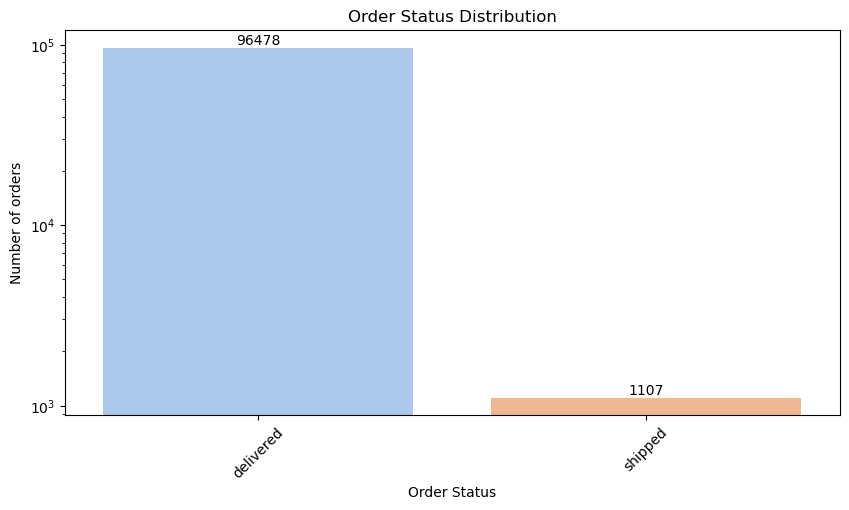

In [97]:
# Orders counts by status

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=orders, x ="order_status", order=orders["order_status"].value_counts(normalize=True).index, palette="pastel")
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Order Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Number of orders")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"
    )
plt.show()



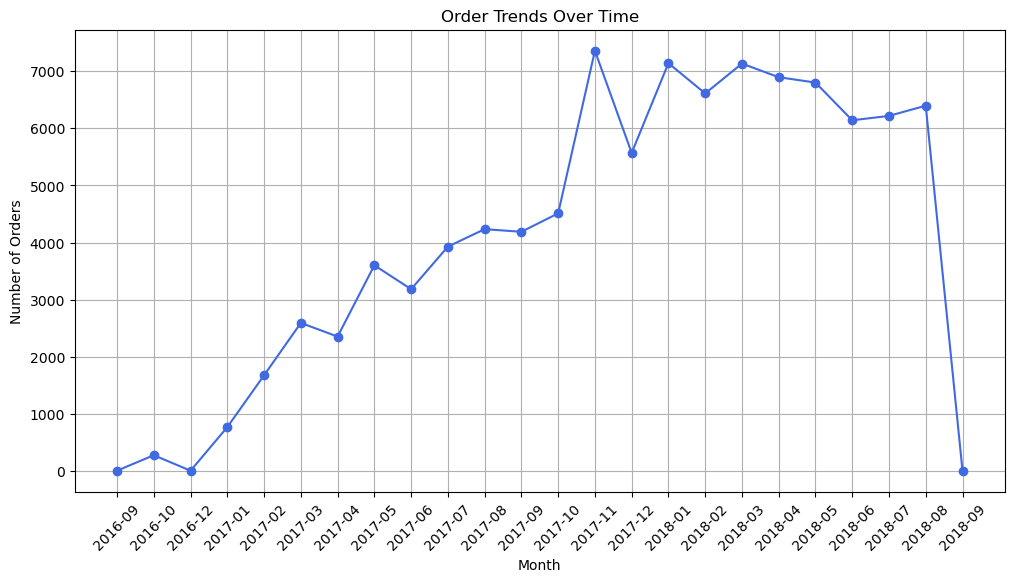

In [98]:
# Orders over time
orders["order_purchase_month"] = orders["order_purchase_timestamp"].dt.to_period(
    "M")
monthly_orders = orders.groupby("order_purchase_month")["order_id"].count()
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index.astype(
    str), monthly_orders.values, marker='o', linestyle="-", color="royalblue")
plt.title("Order Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

There was a growth trend in the number of orders from December 2016 to November 2017, 
followed by a stabilization period from December 2017 to August 2018. However, there was 
a sharp drop in orders from August to October. It's important to check whether there is 
data available for the final months or if the dataset simply ends there.

In [99]:
# Checking if data exists for the last months
print(monthly_orders.tail(30))  # Last 10 months available

order_purchase_month
2016-09       2
2016-10     273
2016-12       1
2017-01     766
2017-02    1674
2017-03    2591
2017-04    2352
2017-05    3601
2017-06    3182
2017-07    3928
2017-08    4234
2017-09    4188
2017-10    4511
2017-11    7361
2017-12    5570
2018-01    7143
2018-02    6612
2018-03    7136
2018-04    6897
2018-05    6803
2018-06    6142
2018-07    6219
2018-08    6398
2018-09       1
Freq: M, Name: order_id, dtype: int64


There were orders, but the quantity is well below normal, indicating that the dataset is likely incomplete for the final and initial months.

### Data Note

The charts indicate that there is a normal pattern in the data, except for the months with less than 500 orders, like: 2016-09, 2016-10, 2016-12, 2018-09 and 2018-10. The likely reason is that the data is incomplete. Therefore, the chosen approach to prevent this discrepancy in order volume from affecting further analyses and models will be remove the rows related to those months.

#### REMOVING ROWS RELATED TO MONTHS WITH DATA DISCREPANCIES

In [100]:
# Call the function to apply the filter and save the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_cleaning import olist_filter_and_save

dfs_filtered = olist_filter_and_save(orders, order_items, payments, customer, products, sellers)


In [101]:
#Accessing the filtered DataFrames from the 'dfs_filtered' dictionary
orders_filtered = dfs_filtered['orders'].copy()
order_items_filtered = dfs_filtered['order_items'].copy()
payments_filtered = dfs_filtered['payments'].copy()
customer_filtered = dfs_filtered['customer'].copy()
products_filtered = dfs_filtered['products'].copy()
sellers_filtered = dfs_filtered['sellers'].copy()

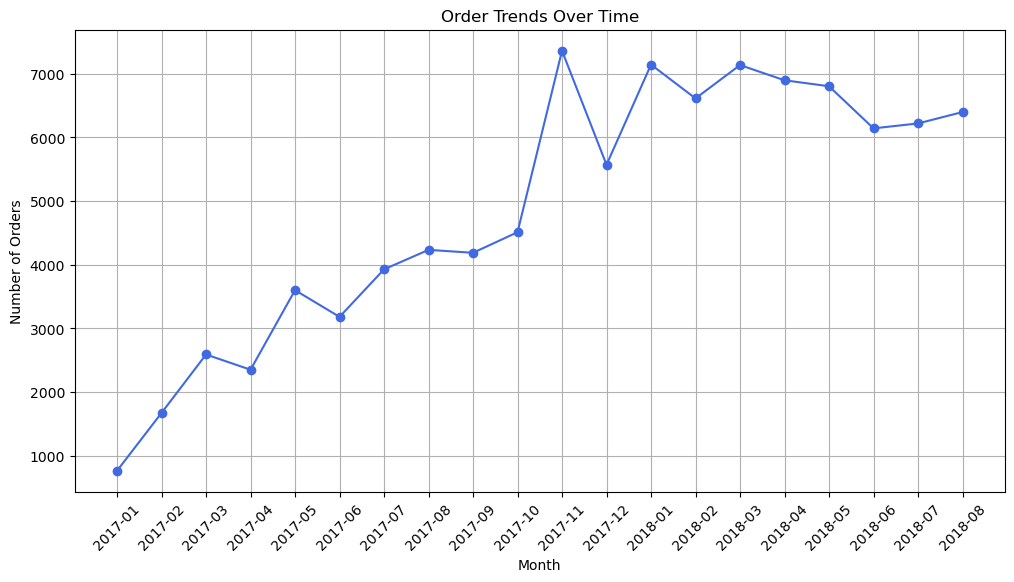

In [102]:
orders_filtered["order_purchase_month"] = orders_filtered["order_purchase_timestamp"].dt.to_period(
    "M")
monthly_orders = orders_filtered.groupby("order_purchase_month")["order_id"].count()
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index.astype(
    str), monthly_orders.values, marker='o', linestyle="-", color="royalblue")
plt.title("Order Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 4. Feature Engineering


In this project, I will perform an in-depth data analysis on a Brazilian marketplace dataset to predict whether an order will be delivered late or not.
I will start by integrating relevant datasets and creating new features that may influence delivery delays.



### Target Variable
The target variable will be a binary feature "is_late", the variable based on the order delivered customer date and order estimated delivery date, indicate if a order was delivered late.

In [103]:
# Was it delivered late?
# Binary feature (0 = on time or early, 1 = late)
orders_filtered["is_late"] = (
    orders_filtered["order_delivered_customer_date"] > orders_filtered["order_estimated_delivery_date"]
).astype(int)

#### Merging the datasets

In [104]:
# Merging the datasets
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from exploratory_data_analysis import merge_datasets
df_merged = merge_datasets( orders_filtered, order_items_filtered, 
    customer_filtered, products_filtered, payments_filtered, 
    sellers_filtered
)

df_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'is_late', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

#### Product Volume Feature
It will be create a feature that represents the product volume. The volume could affect the logistic transportantion, leading possibles order delays.

In [105]:
# Product Volume
df_merged['product_volume'] = df_merged['product_length_cm']*df_merged['product_height_cm']*df_merged['product_width_cm']

#### Distance between customer and seller
The distance between customer and seller could affect the time of transportantion, leading possibles order delays.

In [106]:
# Group by zip code prefix and calculate the coordinates overall mean.
geo_mean = geolocation.groupby('geolocation_zip_code_prefix', as_index = False).agg({
        'geolocation_lat': 'mean',
        'geolocation_lng': 'mean'
})

In [107]:
# Rename from geolocation lat and long to customer lat and long
customer_geo = geo_mean.rename(columns={
    'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

In [108]:
# Rename from geolocation lat and long to seller lat and long
seller_geo = geo_mean.rename(columns={
    'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

In [109]:
# Merge the datagrame customer_geo and seller_geo with df_merged
df_merged = df_merged.merge(customer_geo, on='customer_zip_code_prefix', how='left')
df_merged = df_merged.merge(seller_geo, on='seller_zip_code_prefix', how='left')

In [110]:
# Euclidian distance between customer and seller
df_merged['distance_seller_customer'] = np.sqrt(
    (df_merged['customer_lat'] - df_merged['seller_lat'])**2 +
    (df_merged['customer_lng'] - df_merged['seller_lng'])**2
)

In [111]:
# Describe the distribution
df_merged['distance_seller_customer'].describe()

count    115375.000000
mean          5.555814
std           5.365479
min           0.000000
25%           1.769095
50%           4.083371
75%           7.395559
max          79.600874
Name: distance_seller_customer, dtype: float64

##### Shipping Distance: Outlier Detection and Treatment
Shipping distance plays a crucial role in logistics and delivery performance. However, extreme distances can skew the analysis and influence model training disproportionately. Therefore, before proceeding, it is important to evaluate the presence of outliers in the distance_seller_customer feature

In [112]:
# Checking outilires by IQR method

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from exploratory_data_analysis import detect_outliers_iqr
detect_outliers_iqr(df_merged['distance_seller_customer'])


Number of outliers: 8610
Lower bound: -6.67
Upper bound: 15.84


5         16.512257
35        30.539597
37        18.817106
42        20.496588
44        23.581516
            ...    
115836    20.293948
115846    16.295534
115894    19.787459
115899    21.126148
115921    17.714865
Name: distance_seller_customer, Length: 8610, dtype: float64

Categorizing Shipping Distance

To simplify analysis and uncover non-linear patterns, we transformed the continuous distance between sellers and customers into categorical ranges. The distance distribution is highly skewed, with most deliveries occurring within 10 distance unity.

We defined the following categories based on domain understanding and distribution percentiles:

- `short` (0–10): Local deliveries (majority of cases).
- `medium` (10–20): Regional deliveries.
- `long` (20 – 50): Intermunicipal or short inter-state deliveries.
- `very_long` (50+): Long-distance deliveries potentially more prone to delay.

This transformation allows for clearer visual comparisons and may benefit model interpretability.

In [113]:
# Transform the distance between customer and seller categorical variable.
df_merged['distance_category'] = pd.cut(df_merged['distance_seller_customer'], bins=[0, 10, 20, 50, float('inf')], labels=['short', 'medium', 'long', 'very_long'])


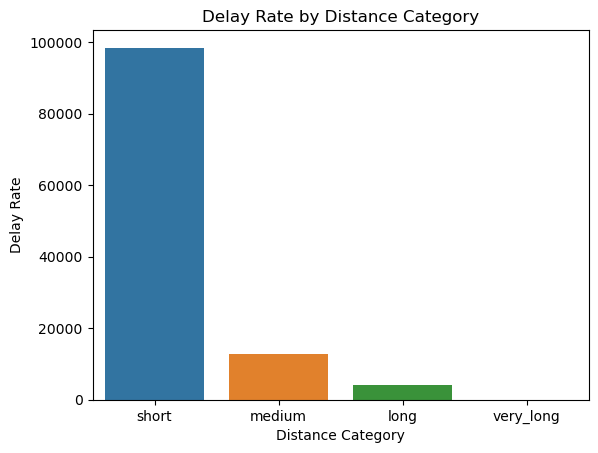

short        0.853679
medium       0.110985
long         0.035328
very_long    0.000009
Name: distance_category, dtype: float64


In [114]:
sns.countplot(x='distance_category', data=df_merged)
plt.title('Delay Rate by Distance Category')
plt.ylabel('Delay Rate')
plt.xlabel('Distance Category')
plt.show()

print(df_merged['distance_category'].value_counts(normalize=True))

#### Estimated time delivery (days)
If the estimated time delivery doesn't fit with the necessary time to delivery the order, could lead to an orders delays.

In [115]:
df_merged['estimated_time'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_approved_at']).dt.days
df_merged['estimated_time'] = df_merged['estimated_time'].fillna(-1).astype(int)


# 5. Exploratory Data Analysis

The focus of this analysis is to explore and analyze the delivery delays of orders in a Brazilian e-commerce marketplace. We will identify patterns related to late deliveries, look for factors that could influence delays.

#### Categorical features
In this section, we analyze the categorical features in our dataset to understand their distribution and relationship with the target variable (e.g., delivery delay).

Key goals:
- Examine the frequency distribution of each categorical variable.
- Identify categories with very low or high frequency.
- Explore possible relationships between categories and delivery outcome

In [116]:
# The dataset merged columns    
df_merged.columns.unique()

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'is_late', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_volume', 'customer_lat', 'customer_lng',
       'seller_lat', 'seller_lng', 'distance_seller_customer',
       'distance_category', 'estimated_time'],
      dtype='object')

In [117]:
# create categorical features dataframe
df_cat = df_merged[[
    'order_purchase_month',
    'customer_state',
    'seller_state',
    'distance_category',
    'is_late'
]]

##### Checking the target variable: "is_late"

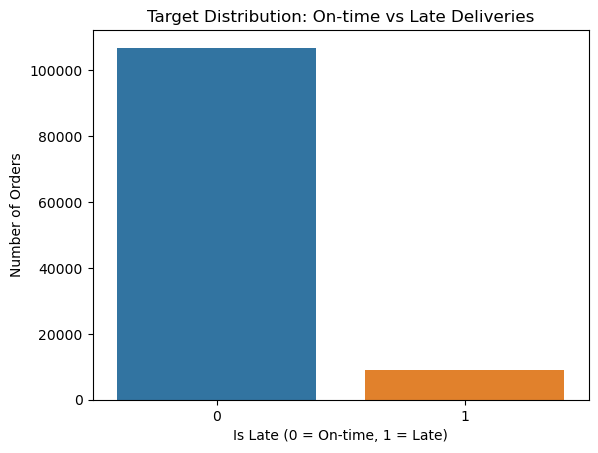

0    0.922198
1    0.077802
Name: is_late, dtype: float64


In [118]:
# Checking the target variable: "is_late" as proportions
sns.countplot(data=df_cat, x='is_late')
plt.title('Target Distribution: On-time vs Late Deliveries')
plt.xlabel('Is Late (0 = On-time, 1 = Late)')
plt.ylabel('Number of Orders')
plt.show()

print(df_cat['is_late'].value_counts(normalize=True))


Proportion of Late Deliveries

This bar plot shows the proportion of orders that were delivered on time (`is_late = 0`) versus those delivered late (`is_late = 1`). This visualization is important to identify class imbalance before modeling

##### Monthly Delivery Delay Rate

To better understand delivery performance over time, we analyzed the proportion of late deliveries grouped by order month. The line chart below illustrates how frequently orders were delivered late on a monthly basis.

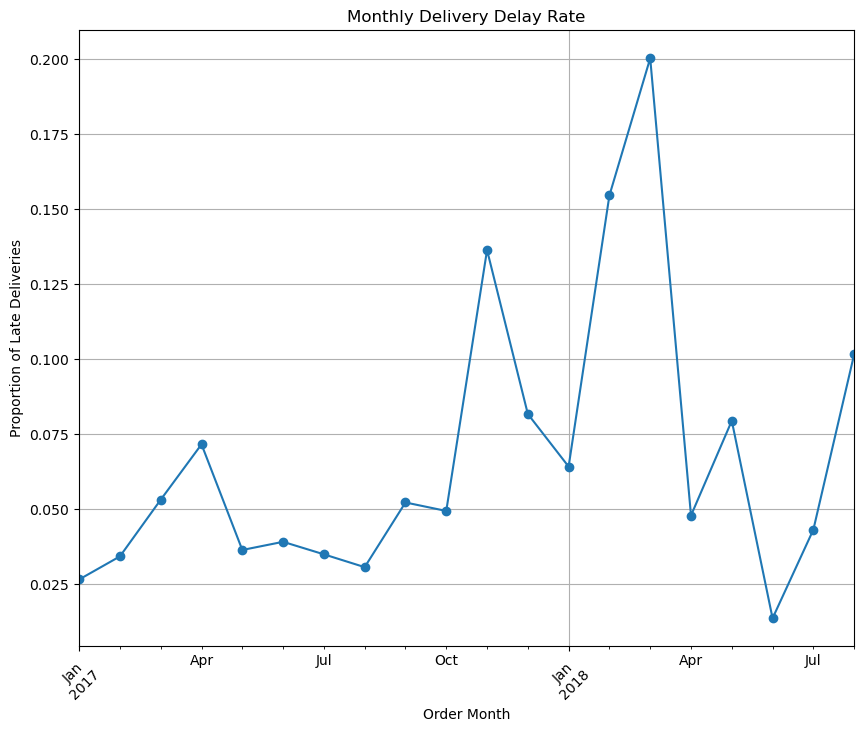

In [119]:
# Plot Monthly delivery delay rate
monthly_delay_rate = df_merged.groupby('order_purchase_month')['is_late'].mean()
monthly_delay_rate.plot(marker='o', figsize=(10,8))
plt.title('Monthly Delivery Delay Rate')
plt.ylabel('Proportion of Late Deliveries')
plt.xlabel('Order Month')
plt.xticks(rotation=45)
plt.grid()
plt.show()


From the chart, we can observe the following patterns:

Low delay rates in early 2017, with proportions typically under 5%.

A noticeable increase starting in late 2017, with the peak delay rate occurring around February 2018, where 20% of the orders were late.

After the peak, there is high volatility in delay rates, with fluctuations between 1% and 15%, suggesting that delivery punctuality was inconsistent in mid to late 2018.

##### Outlier Detection

In [120]:
# Calculate monthly late delivery rate
monthly_delay_rate = df_cat.groupby('order_purchase_month')['is_late'].mean()

# Describe the distribution
delay_stats = monthly_delay_rate.describe()
print(delay_stats)


count    20.000000
mean      0.067508
std       0.047642
min       0.013572
25%       0.035972
50%       0.050758
75%       0.079968
max       0.200259
Name: is_late, dtype: float64


In [121]:
# Calculate IQR (Interquartile Range)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from exploratory_data_analysis import detect_outliers_iqr
detect_outliers_iqr(monthly_delay_rate)


Number of outliers: 2
Lower bound: -0.03
Upper bound: 0.15


order_purchase_month
2018-02    0.154534
2018-03    0.200259
Freq: M, Name: is_late, dtype: float64

Although February and March 2018 was identified as a statistical outlier due to an unusually high delivery delay rate, it was intentionally retained in the dataset.

This decision was made to enhance the robustness of the predictive model. Real-world delivery systems are subject to unexpected disruptions such as holidays, strikes, weather events, or sudden demand spikes. By including this atypical month, the model is exposed to more realistic variations, making it better prepared to generalize and handle similar anomalies in future predictions.

Removing outliers can lead to cleaner models but may reduce their ability to capture critical edge cases. In this case, preserving the outlier helps build a model that is not only accurate under normal conditions but also resilient in extreme situations.

#### Delivery Delay vs. Shipping Distance

In this section, we explore how the geographical distance between sellers and customers influences delivery delays.

Intuitively, longer shipping distances may lead to increased delivery times and a higher probability of delays, especially in a large country like Brazil where logistics vary significantly across regions.

By analyzing this relationship, we aim to uncover whether distance is a significant driver of late deliveries, and if it should be considered a key feature in our predictive model.

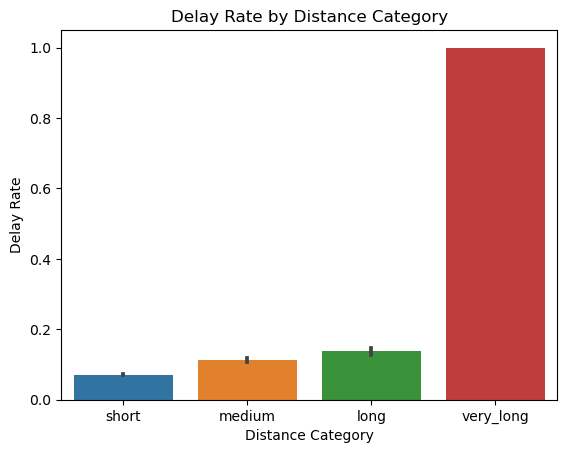

In [122]:
# Plotting delay rate by distance category
sns.barplot(x='distance_category', y='is_late', data=df_cat)
plt.title('Delay Rate by Distance Category')
plt.ylabel('Delay Rate')
plt.xlabel('Distance Category')
plt.show()


In [123]:
df_merged['distance_category'].value_counts()


short        98471
medium       12802
long          4075
very_long        1
Name: distance_category, dtype: int64

Removing Extremely Rare Distance Category

During the analysis of delay rates by distance category, we identified that the very_long category contains only one observation.
Keeping this outlier category would introduce a misleading impression of 100% delay rate, which lacks statistical reliability.
Therefore, to preserve the consistency and robustness of the analysis, we removed this record and excluded the category.

In [124]:
# Removing distance category very long
df_cat = df_cat[df_cat['distance_category'] != 'very_long']
df_merged = df_merged[df_merged['distance_category'] != 'very_long']
df_cat['distance_category'] = df_cat['distance_category'].astype('category')
df_cat['distance_category'] = df_cat['distance_category'].cat.remove_unused_categories()


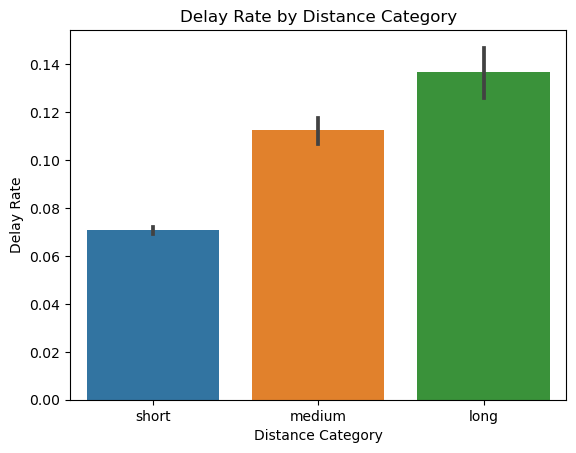

In [125]:
# Plotting delay rate by distance category
sns.barplot(x='distance_category', y='is_late', data=df_cat)
plt.title('Delay Rate by Distance Category')
plt.ylabel('Delay Rate')
plt.xlabel('Distance Category')
plt.show()

The chart shows the delay rate for three distance categories: short, medium, and long.

Key Points:
- Short distances have the lowest delay rate (~7%).
- Medium distances show a moderate increase (~11%).
- Long distances have the highest delay rate (~13.7%).

Conclusion:
There is a clear pattern: as distance increases, so does the delay rate. This makes sense, as longer distances usually involve more risks and logistics challenges.


#### Numeric Features
In this section, we explore the numerical variables in the dataset to better understand their distribution, identify outliers, and check for patterns that might affect delivery delays. Basic statistics and visualizations will help us prepare the data for modeling.




In [126]:
# selecting numeric features
df_numeric = df_merged[['product_volume',
                        'product_weight_g',
                        'freight_value',
                        'payment_value',
                        'price',
                        'estimated_time'
]]

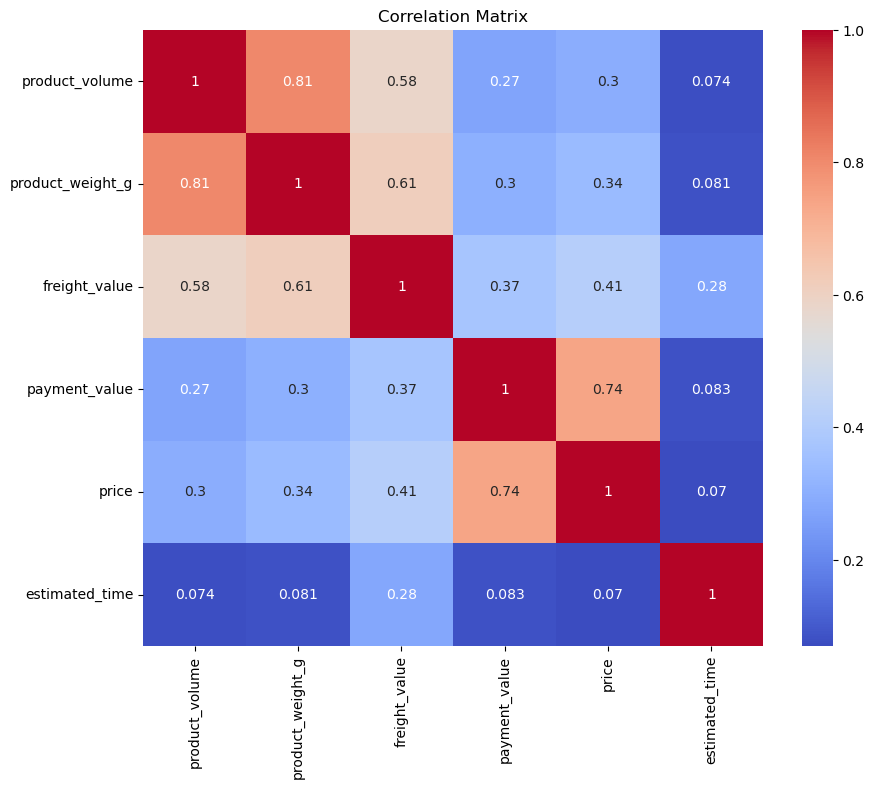

In [127]:
# Checking correlation between numeric features
corr = df_numeric.select_dtypes(include='number').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from exploratory_data_analysis import calculate_vif

# Calculating Variance Inflation Factor (VIF) to detect multicollinearity
# VIF > 5 suggests moderate correlation; VIF > 10 indicates high multicollinearity

vif = calculate_vif(df_numeric)
display(vif)

,feature,VIF
0,product_volume,4.227323
1,product_weight_g,4.144138
2,freight_value,5.089449
3,payment_value,3.157822
4,price,3.326094
5,estimated_time,2.868193


Multicollinearity Check using VIF

We calculated the Variance Inflation Factor (VIF) to assess multicollinearity among the numerical features. All VIF values are below or equal 5, which indicates no strong multicollinearity is present. Therefore, all variables can be safely used in further modeling or analysis.

##### Box Plot visualization
In this step, we create box plots for each numeric variable to visualize their distribution across delivery statuses (on-time vs. late). These plots help us compare how continuous features like product volume, freight value, and estimated delivery time differ between on-time and delayed deliveries, highlighting potential factors associated with delivery performance.

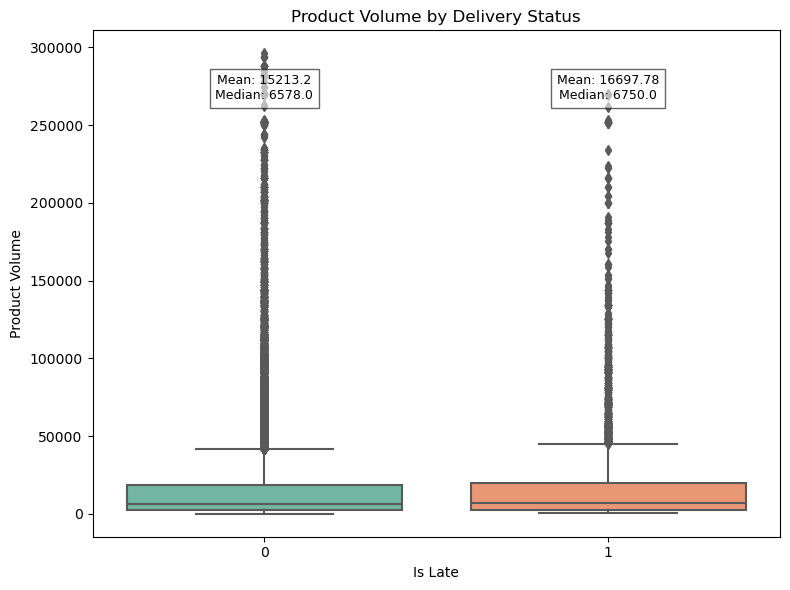

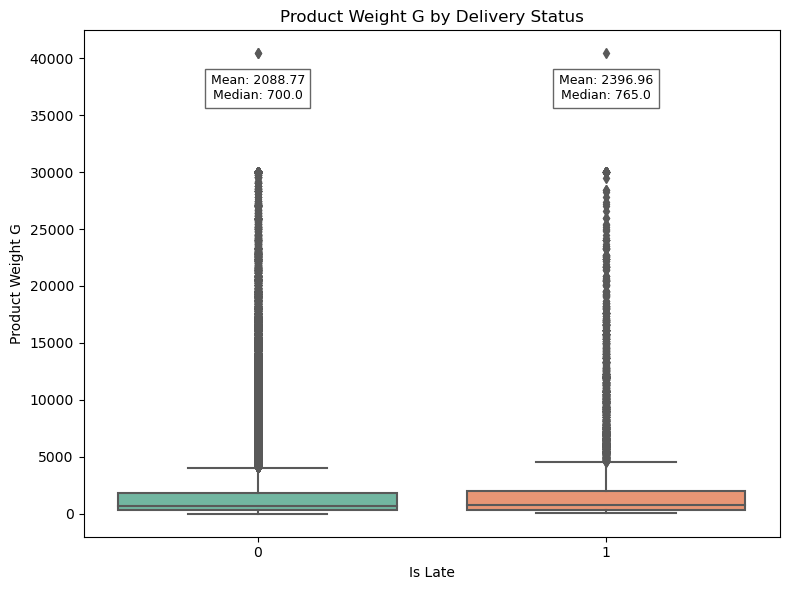

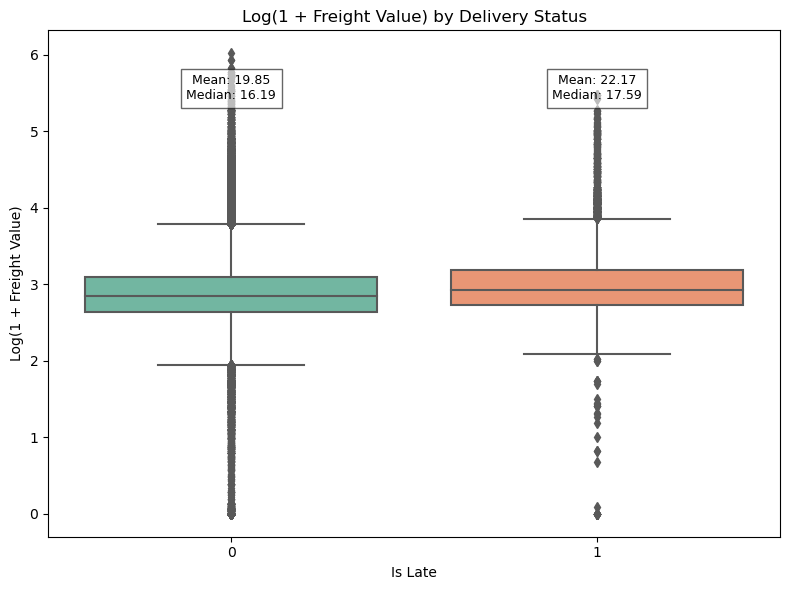

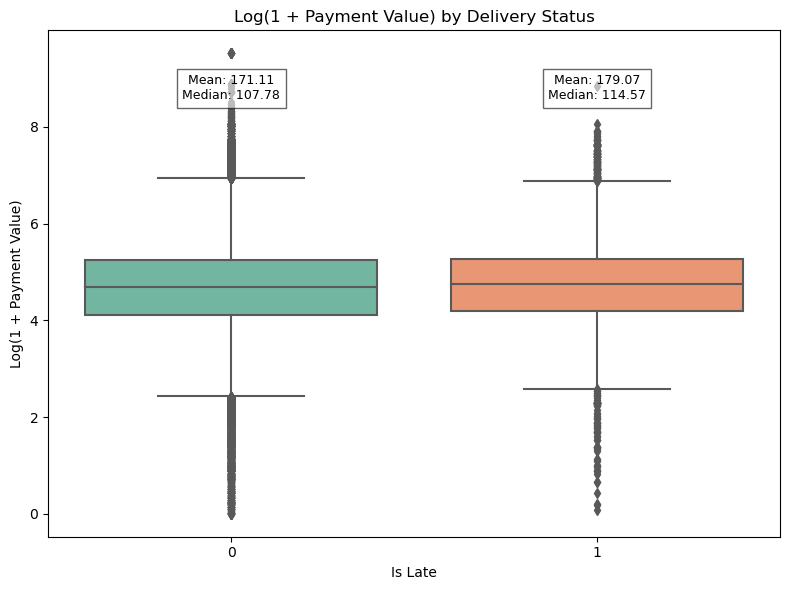

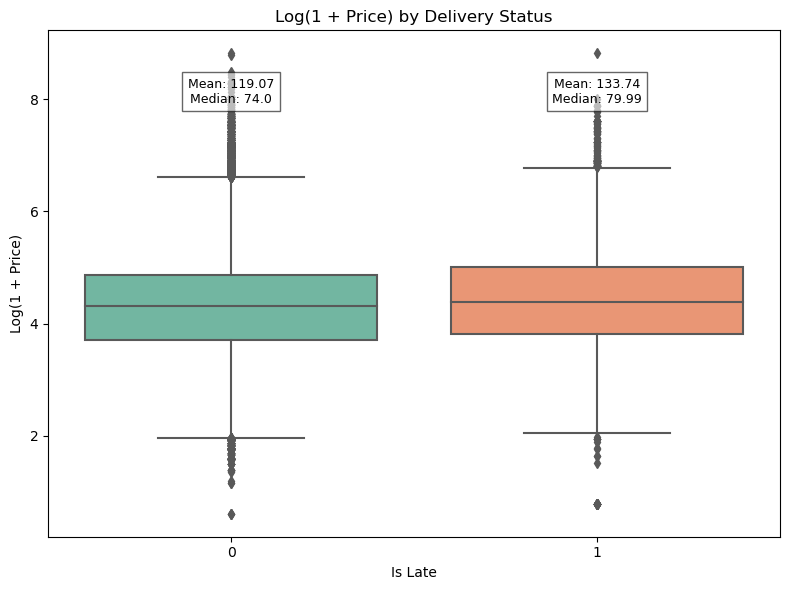

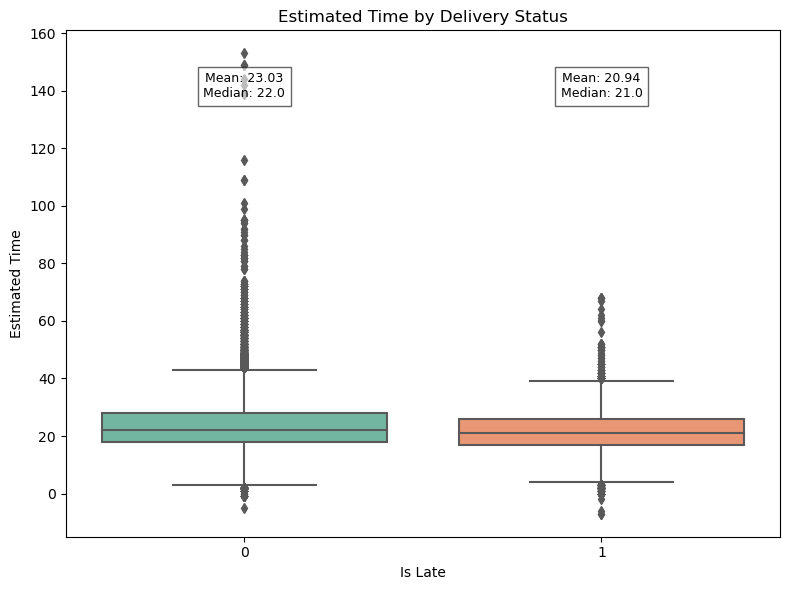

In [129]:
# Boxplots
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from exploratory_data_analysis import plot_boxplots_by_delivery

plot_boxplots_by_delivery(df_merged, df_numeric)


##### Outlier Handling and Feature Evaluation Strategy

During the exploratory analysis, we observed a significant number of outliers in several numerical features such as `freight_value`, `payment_value`, and `price`. Interestingly, although the average and median values of these features are quite similar between delayed and non-delayed deliveries, the presence of extreme values raises important considerations.

It is crucial to emphasize that **mean and median alone are not sufficient criteria** for determining whether a feature is informative for predictive modeling. Machine learning models, particularly tree-based algorithms such as Random Forests or Gradient Boosted Trees, are capable of learning from complex, non-linear patterns in the data—including **relationships involving rare or extreme values**. Therefore, the existence of outliers could signal meaningful edge cases, such as very high freight costs or long delivery distances that are more likely to result in delays.

Rather than discarding or aggressively transforming these outliers at this stage, we choose to retain them. This decision allows the model to **learn from the natural distribution of the data**, including any extreme behaviors that may correlate with the target variable.

To rigorously evaluate the relevance of each feature, we will later employ a **stratified k-fold cross-validation strategy**. This approach ensures that each fold preserves the proportion of delayed and non-delayed deliveries, which is particularly important given the class imbalance. Using this framework, we will extract **feature importance scores** from models such as Random Forests to identify which variables contribute most to the prediction task.

By deferring feature selection to this model-based evaluation, we aim to capture patterns and interactions that are not evident from summary statistics alone.


### Strategy for Preliminary Modeling and Feature Evaluation

Our dataset consists of both numerical (`df_numeric`) and categorical (`df_cat`) features. While the numerical features are ready for modeling, the categorical features still require preprocessing—such as encoding into binary variables using techniques like get dummies.

To assess the potential predictive power of the entire dataset, we propose the following two-step modeling strategy:

1. **Baseline Model (Preliminary):**  
   We will first train a baseline model using both numerical and raw categorical features (after minimal encoding), without performing feature selection. This will serve as a reference point to understand how the model behaves with all available information, including outliers and potentially irrelevant variables.

2. **Model with Feature Importance and Preprocessing:**  
   In the second step, we will build a refined model pipeline where categorical variables are properly encoded, and we use `StratifiedKFold` cross-validation to evaluate the model performance. Here, feature importance scores will help us identify and possibly drop uninformative or redundant variables. By comparing the performance metrics of this model against the baseline, we can assess the value of preprocessing and feature selection.

Since our target variable (`is_late`) is **highly imbalanced**, both models will be evaluated using metrics that account for this imbalance—such as **Recall, F1-score, and ROC AUC**. We will also consider techniques like **class weighting** or **resampling** in the pipeline if needed.

This strategy enables a structured and data-driven approach to understanding how each feature contributes to model performance.


#### Baseline Model
To begin, we apply one-hot encoding to transform the categorical variables into a machine-readable format. This is a lightweight approach, enough to allow us to build a preliminary model. The goal is to establish a performance baseline before we move into more complex feature engineering.

In [130]:
# Pré processing of categorical features
# Combining numerical and categorical features after minimal preprocessing

# Separate target before encoding
y = df_cat['is_late']  # Store target variable
df_cat = df_cat.drop(columns='is_late')  # Remove it from categorical features

# Convert order_purchase_month from period to date
df_cat['order_purchase_month'] = df_cat['order_purchase_month'].dt.month

# get dummies for categorical features
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)

# Combine numerical and categorical features
X = pd.concat([df_numeric, df_cat_encoded], axis=1)


Baseline model training with StratifiedKFold

We train a Random Forest classifier using 5-fold Stratified Cross-Validation. This technique ensures the distribution of the target class remains balanced across the folds. We also apply `class_weight='balanced'` to address class imbalance in our target (`is_late`). This baseline model provides reference metrics for comparison with future models that include feature selection and deeper preprocessing.


In [131]:
# Train a baseline model using StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, roc_auc_score, precision_score

# Initialize model with class weights to handle imbalance
model = RandomForestClassifier(random_state=42, max_depth = 5, class_weight='balanced')

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform cross-validation
results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Display mean results
for metric in scoring.keys():
    print(f"{metric.title()}: {results[f'test_{metric}'].mean():.4f}")

Accuracy: 0.7133
Precision: 0.1568
Recall: 0.6129
F1: 0.2497
Roc_Auc: 0.6674


##### Feature selection

After training the model, we examine the importance scores of each feature. This helps us identify variables that contribute significantly to the model’s decision-making process. Variables with very low importance could potentially be removed in the next iteration to reduce dimensionality and improve generalization.

To address this, we apply Recursive Feature Elimination with Cross-Validation (RFECV), a technique that recursively removes less important features and evaluates model performance using cross-validation at each step. This method helps to automatically determine the optimal number of features that contribute the most to the predictive power of the model.

By combining feature elimination with cross-validation, RFECV ensures that the selected feature subset maintains strong generalization performance while simplifying the model.

In [132]:
from sklearn.feature_selection import RFECV
# Initialize RFECV with the baseline model
rfecv = RFECV(
    estimator=model,  # your baseline RandomForestClassifier
    step=1,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

# Fit RFECV to select the most relevant features
rfecv.fit(X, y)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                       random_state=42),
      n_jobs=-1, scoring=make_scorer(f1_score, response_method='predict'))

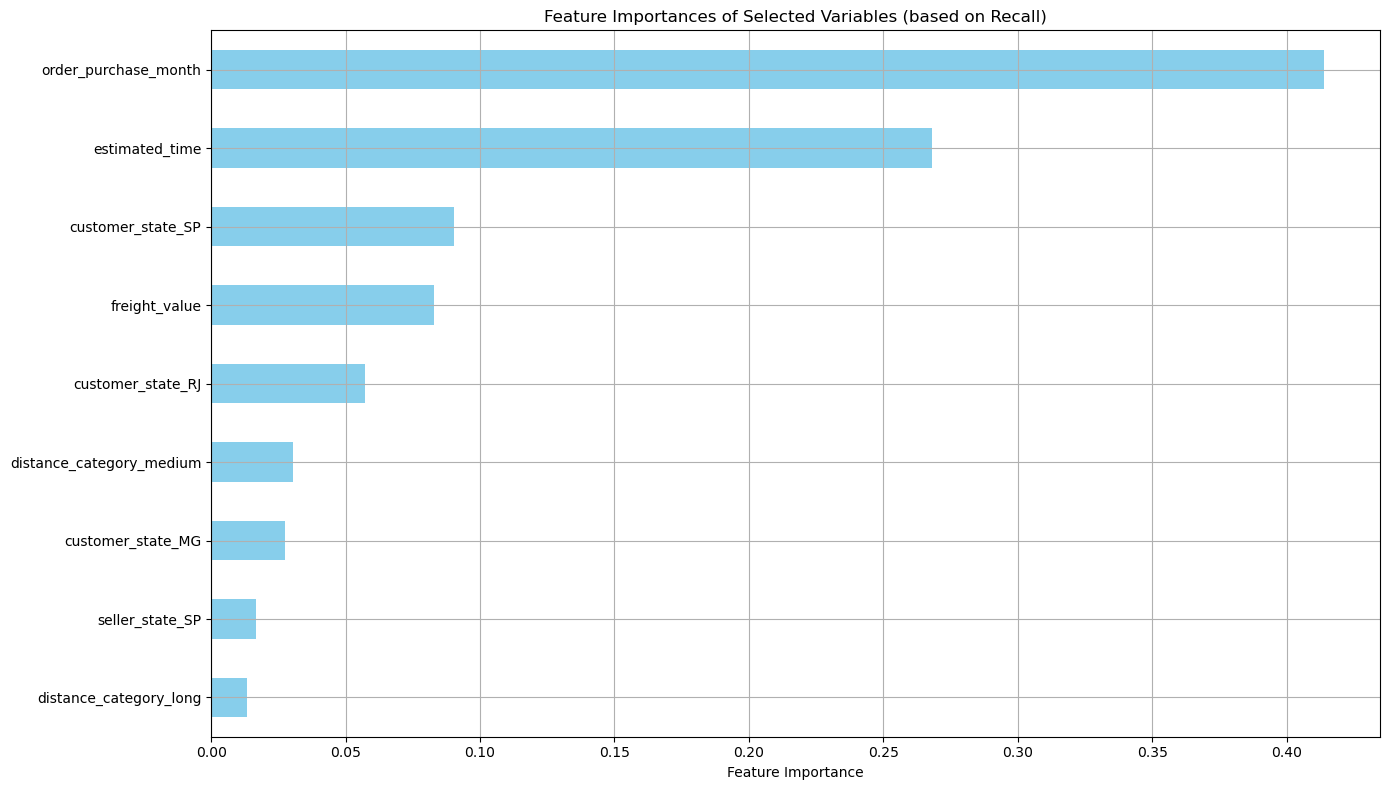

In [133]:
# Get the mask of selected features from RFECV
selected_features = X.columns[rfecv.support_]

# Train the model again using only the selected features
model.fit(X[selected_features], y)

# Extract feature importances
importances = pd.Series(model.feature_importances_, index=selected_features).sort_values(ascending=True)

# Plot feature importances
plt.figure(figsize=(14, 8))
importances.tail(20).plot(kind='barh', color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances of Selected Variables (based on Recall)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [134]:
# Model re-evaluate (cross-validation with seleceted features)

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Evaluate using cross-validation
results = cross_validate(model, X[selected_features], y, cv=cv, scoring=scoring)

# Display the average of each metric
for metric in scoring.keys():
    print(f"{metric}: {results['test_' + metric].mean():.4f}")


accuracy: 0.7545
recall: 0.5908
precision: 0.1770
f1: 0.2724
roc_auc: 0.6795


In this exploratory data analysis, we performed an extensive examination of the dataset to understand its structure, distribution, and relationships among features with respect to the target variable is_late.
We Applied techniques such as Recursive Feature Elimination with Cross-Validation (RFECV) to identify the most relevant features.
Developed baseline model using Random Forest and validating using Stratified K-Fold.

Next Steps:
- Model building
- Evaluation
- Improvement iterations

In [135]:
# Saving dataset to modeling steps
df_model = pd.concat([df_numeric, df_cat, y], axis=1)
current_dir = os.getcwd()
data_path = os.path.abspath(os.path.join(current_dir, "..", "data", "processed"))
file_path = os.path.join(data_path, 'df_model.parquet')
df_model.to_parquet(file_path)